In [4]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 1. Load Pretrained Feautre

## VGG

![](../resources/vgg19.png)

In [5]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 2. Load Image

In [7]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert("RGB")
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = in_transform(image).unsqueeze(0)
    return image

In [8]:
class DeNormalize(transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

In [9]:
def im_convert(tensor):
    transform = transforms.Compose([DeNormalize((0.5,), (0.5,))])
    tensor = tensor.squeeze()
    tensor = transform(tensor.clone().detach())
    tensor = tensor.permute(1,2,0)
    image = tensor.clip(0,1).cpu()
    return image

In [10]:
content = load_image("../data/Images/City.jpg").to(device)
# content = load_image("../data/Images/Monalisa.jpg").to(device)
style = load_image("../data/Images/StarryNight.jpg", shape=content.shape[-2:]).to(device)

(-0.5, 599.5, 399.5, -0.5)

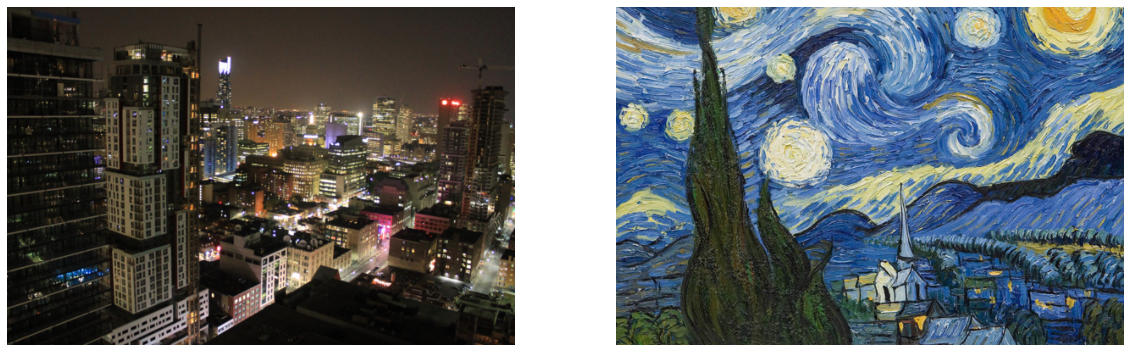

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")

# 3. Feature Extraction

In [12]:
def get_features(image, model):
    layers = {"0": "conv1_1",
             "5": "conv2_1",
             "10": "conv3_1",
             "19": "conv4_1",
             "21": "conv4_2", #content extraction
             "28": "conv5_1",}
    features = {}
    
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image

    return features
            

In [15]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# 4. The Gram Matrix

In [14]:
def gram_matrix(tensor):
    _,d,h,w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [26]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [19]:
style_weights = {"conv1_1": 1.,
                 "conv2_1": 0.75,
                 "conv3_1": 0.2,
                 "conv4_1": 0.2,
                 "conv5_1": 0.2}

content_weight = 1
style_weight = 1e6

In [20]:
target = content.clone().requires_grad_(True)

# 5. Optimization

In [21]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 2100
height, wieght, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, wieght, channels))
capture_frame = steps/300
counter = 0

Total loss: 2887704.5
Iterations: 300


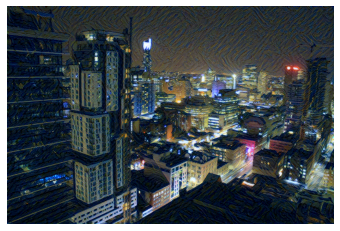

Total loss: 949960.5
Iterations: 600


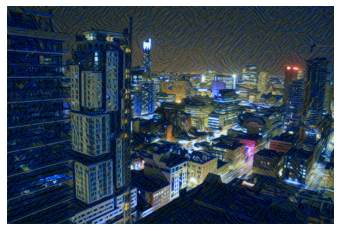

Total loss: 658546.375
Iterations: 900


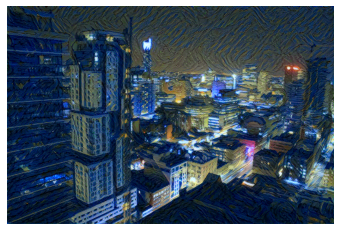

Total loss: 510558.15625
Iterations: 1200


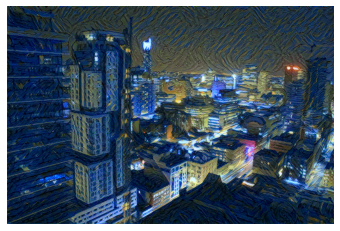

Total loss: 400851.59375
Iterations: 1500


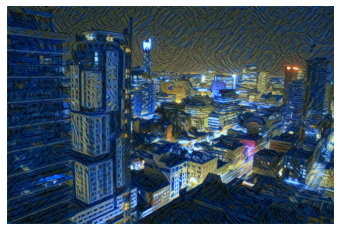

Total loss: 314953.625
Iterations: 1800


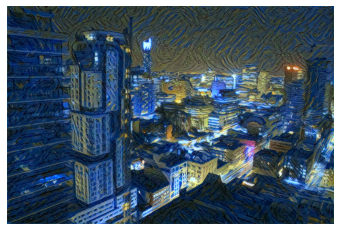

Total loss: 246872.953125
Iterations: 2100


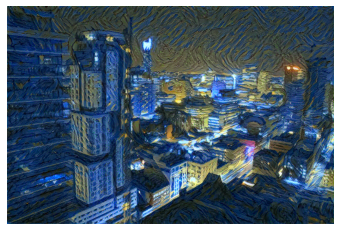

In [27]:
for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"])**2)
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss +=layer_style_loss / (d * h * w)
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii % show_every == 0:
        print(f"Total loss: {total_loss.item()}")
        print(f"Iterations: {ii}")
        plt.imshow(im_convert(target))
        plt.axis("off")
        plt.show()
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter = counter + 1

(-0.5, 599.5, 399.5, -0.5)

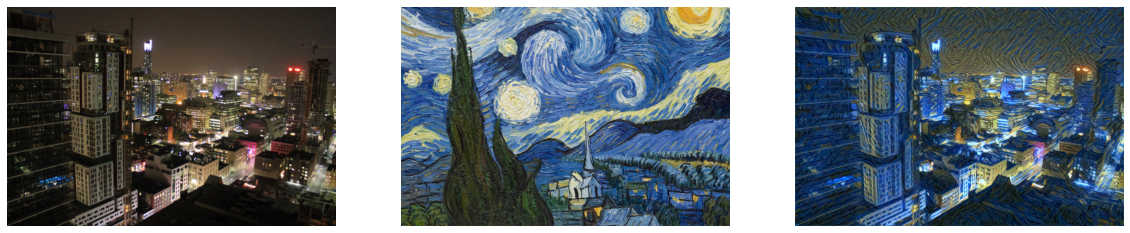

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")
ax3.imshow(im_convert(target))
ax3.axis("off")

# 6. Style Transfer With Video

In [ ]:
import cv2

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter("../resources/output.mp4", cv2.VideoWriter_fourcc(*"mp4v"), 30, (frame_width, frame_height))

for i in range(0, 300):
    img = image_array[i]
    img = img * 255
    img = np.array(img, dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vid.write(img)
vid.release()                     